# Grid setup LUT

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm
import networkx as nx

# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

## Functions

In [2]:
def get_neighborhood(point, points, max_dist):
    # Get the Euclidean distance between the point and all other points
    distances = np.linalg.norm(points - point, axis=1)
    
    # Get the indices of the points within the neighborhood
    neighborhood_indices = np.where(distances <= max_dist)[0]
    
    # Get the points within the neighborhood
    neighborhood = points[neighborhood_indices]
    
    #neighborhood = [pt for pt in neighborhood if pt != point]
    
    return neighborhood_indices, neighborhood


def get_magnitude(v):
    return np.linalg.norm(v)


def angle_between_vectors(v1, v2):
    # arccos (A dot B / |A||B|)
    # Compute the dot product
    dot_product = np.dot(v1, v2)
    
    # Compute the magnitudes of the vectors
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0, 0
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Clip the cosine value to the range [-1, 1] to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_rad, angle_deg

m1 = np.array([0, 1, 0])
f1 = np.array([0, 1, 4])

m2 = np.array([0, 3, 0])
f2 = np.array([0, 4, 4])

# Example vectors
# v1 = np.array([1, 0, 0])
# v2 = np.array([1, 0.5, 0])

v1 = f1 - m1
v2 = f2 - m2

# Compute the angle between the vectors
angle_rad, angle_deg = angle_between_vectors(v1, v2)

# Check if the angle exceeds a certain threshold (e.g., 45 degrees)
threshold_deg = 45
if angle_deg > threshold_deg:
    print(f"The vectors differ by a lot: {angle_deg:.2f} degrees")
else:
    print(f"The vectors do not differ by a lot: {angle_deg:.2f} degrees")
    
    
def get_negative_jdet_coordinates(jdet_field: np.ndarray) -> np.ndarray:
    """
    Get the coordinates of the negative values in the Jacobian determinant field.
    
    Parameters
    ----------
    jdet_field : np.ndarray
        The Jacobian determinant field.
    
    Returns
    -------
    np.ndarray
        The coordinates of the negative values
    """
    # Get the indices of the negative values
    indices = np.where(jdet_field <= 0)
    
    # Get the coordinates of the negative values
    coordinates = np.column_stack((indices[0], indices[1]))
    
    return coordinates



def label_correspondences(fpoints: np.ndarray, jdet_field: np.ndarray):
    """
    Label the correspondences with the Jacobian determinant value.
    
    Parameters:
    fpoints (np.ndarray): The fixed points.
    jdet_field (np.ndarray): The Jacobian determinant field.
    
    Returns:
    np.ndarray: The labeled correspondences.
    """
    # Initialize the labeled correspondences
    labeled_correspondences = []
    
    # Iterate through each correspondence
    for i in range(len(fpoints)):
        curr_fpt = fpoints[i].astype(int)
        _, y, x = curr_fpt
        jdets = []
        if x != 0:
            left_jdet = jdet_field[y, x - 1]
            jdets.append(left_jdet)
        if x != jdet_field.shape[1] - 1:
            right_jdet = jdet_field[y, x + 1]
            jdets.append(right_jdet)
        if y != 0:
            up_jdet = jdet_field[y - 1, x]
            jdets.append(up_jdet)
        if y != jdet_field.shape[0] - 1:
            down_jdet = jdet_field[y + 1, x]
            jdets.append(down_jdet)
        jdet_value = jdet_field[y, x]
        jdets.append(jdet_value)
        
        # Label the correspondence bad if any of the Jacobian determinants are negative
        if np.min(jdets) <= 0:
            labeled_correspondences.append(0)
        else:
            labeled_correspondences.append(1)
    return labeled_correspondences

The vectors do not differ by a lot: 14.04 degrees


## Create LUT test cases

In [3]:
def create_grid(deformation: np.ndarray, jdet_field: np.ndarray, fpoints: np.ndarray, mpoints: np.ndarray):
    """
    Creates a full grid of correspondence information.
    
    Parameters:
    jdet_field (np.ndarray): The Jacobian determinant field.
    fpoints (np.ndarray): The fixed points.
    mpoints (np.ndarray): The moving points.
    
    Returns:
    np.ndarray: The grid of points. Each element contains the following information:
        - y (int): The y-coordinate of the point.
        - x (int): The x-coordinate of the point.
        - theta (float): The angle of the vector relative to the x-axis.
        - magnitude (float): The magnitude
        - Jdet (float): The Jacobian determinant value at the point.
        - is_correspondence (bool): Whether the point is a correspondence.
    """
    # Initialize the grid as an object array
    grid_y = np.empty(jdet_field.shape, dtype=np.int16)
    grid_x = np.empty(jdet_field.shape, dtype=np.int16)
    grid_theta = np.empty(jdet_field.shape, dtype=np.float16)
    grid_magnitude = np.empty(jdet_field.shape, dtype=np.float16)
    grid_jdet = np.empty(jdet_field.shape, dtype=np.float16)
    grid_correspondence = np.zeros(jdet_field.shape, dtype=bool)

    # Store all information about correspondences into the grid
    y_resolution = jdet_field.shape[0]
    x_resolution = jdet_field.shape[1]
    curr_deformation = deformation[:, 0, :, :]  # (3, 320, 456)
    for y in tqdm(range(y_resolution)):
        for x in range(x_resolution):
            curr_displacement_vector = curr_deformation[:, y, x]
            _, displacement_y, displacement_x = curr_displacement_vector
            
            
            # Get current pixel information
            theta = np.arctan2(displacement_y, displacement_x)                # Angle of the vector relative to the x-axis
            if theta < 0:  # Ensure the angle is in the range [0, 2pi)
                theta += 2 * np.pi
            magnitude = np.linalg.norm(curr_displacement_vector)              # Magnitude of the vector
            jdet_value = jdet_field[y, x]                                     # Jacobian determinant value
            is_correspondence = np.any(np.all([0, y, x] == fpoints, axis=1)) or np.any(np.all([0, y, x] == mpoints, axis=1)) # Whether the point is a correspondence
            
            # Place these values into the grid
            grid_y[y, x] = y
            grid_x[y, x] = x
            grid_theta[y, x] = theta
            grid_magnitude[y, x] = magnitude
            grid_jdet[y, x] = jdet_value
            grid_correspondence[y, x] = is_correspondence
        
    return [grid_y, grid_x, grid_theta, grid_magnitude, grid_jdet, grid_correspondence]


def show_grid(grids: list, mpoints, fpoints, title="", fontsize=8):
    """
    Show the grid of deformation information.
    
    Parameters:
    grids (list): The grid of deformation information.
    """
    grid_y, grid_x, grid_theta, grid_magnitude, grid_jdet, grid_correspondence = grids
    norm = mcolors.TwoSlopeNorm(vmin=min(grid_jdet.min(), -1), vcenter=0, vmax=grid_jdet.max())
    
    # Plot the grid of deformation information
    f = plt.figure(figsize=(10, 5))
    
    
    # Plot the grid of Jacobian determinants color values
    plt.imshow(grid_jdet, cmap="seismic", norm=norm)
    plt.colorbar()
    
    for i in range(len(fpoints)):
        plt.annotate(
            '', 
            xy=(fpoints[i][2], fpoints[i][1]), 
            xytext=(mpoints[i][2], mpoints[i][1]), 
            arrowprops=dict(color='green', shrink=0.045, headwidth=4, headlength=5, width=1)
        )
    
    # Plot the coordinate text
    for j in range(grid_y.shape[0]):
        for i in range(grid_y.shape[1]):
            # Get the pixel information
            y = grid_y[j, i]
            x = grid_x[j, i]
            degrees = grid_theta[j, i]
            magnitude = grid_magnitude[j, i]
            jdet = grid_jdet[j, i]
            is_correspondence = grid_correspondence[j, i]
            
            # Setup text to display
            coord_text = f"({y}, {x})\n"
            vector_text = f"\n{degrees:.2f}°\n" + f"∥{magnitude:.2f}∥"
            jdet_text = f"{jdet:.2f} J"
            pixel_text = coord_text + jdet_text + vector_text
            if is_correspondence:
                text_weight = "bold"
            else:
                text_weight = "normal"
            plt.text(i, j, pixel_text, color='black', ha='center', va='center', fontsize=fontsize, weight=text_weight)

    # Set the xticks and yticks
    plt.xticks(np.arange(grid_x.shape[0]), labels=np.arange(np.min(grid_x), np.max(grid_x) + 1))
    plt.yticks(np.arange(grid_y.shape[0]), labels=np.arange(np.min(grid_y), np.max(grid_y) + 1))
    
    # Set the title
    plt.title(title)
    
    plt.show()
    f.clear()
    plt.close(f)


def create_correspondence(y, x, angle, magnitude):
    angle = np.radians(angle)
    mpoint = np.array([0, y, x])
    fpoint = np.array([0, y + np.sin(angle) * magnitude, x + np.cos(angle) * magnitude])
    return mpoint, fpoint

In [ ]:
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle 

n = 7
SAVE_TO_FILE = True

# Setup initial correspondence in the center pixel.
mpoints = np.array([[0, (n // 2), (n // 2)]])
fpoints = np.array([[0, (n // 2), (n // 2) + 1]])
fixed_resolution = np.zeros((1, n, n))

# Define a function to create a nested defaultdict
def nested_dict():
    return defaultdict(nested_dict)
data = nested_dict()

# Create a range of correspondences for each pixel
for y in tqdm(range(n), desc="Outer loop y"):
    for x in tqdm(range(n), desc="Outer loop x", leave=False):
        if y == (n // 2) and x == (n // 2):
            continue
        # Create correspondences for each angle (degrees)
        for angle in tqdm(range(0, 360, 10), desc="Inner loop angle", leave=False):
            # Create correspondences for each magnitude from 0.5 to 5.0
            for magnitude in tqdm(range(1, 11), desc="Innermost loop magnitude", leave=False):
                magnitude /= 2
                # Create the correspondence and apply as the second correspondence in the grid
                mpoint, fpoint = create_correspondence(y, x, angle, magnitude)
                curr_mpoints = mpoints.copy()
                curr_fpoints = fpoints.copy()
                curr_mpoints = np.append(curr_mpoints, [mpoint], axis=0)
                curr_fpoints = np.append(curr_fpoints, [fpoint], axis=0)
                # Run Laplacian and Jacobian determinant calculations and save the Jacobian determinant field
                deformation, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
                jdet_field = jacobian.sitk_jacobian_determinant(deformation)[0]
                data[y][x][angle][magnitude] = jdet_field

# Pickle the nested dictionary to a file
if SAVE_TO_FILE:
    with open('lut_data.pkl', 'wb') as file:
        pickle.dump(data, file)

Outer loop y:   0%|          | 0/7 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop x:   0%|          | 0/7 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop angle:   0%|          | 0/36 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

Innermost loop magnitude:   0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
# Load the pickled dictionary from the file
with open('lut_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Example of accessing the loaded data
print(loaded_data[2][2][10][1.5])

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [ ]:
def show_data(data: dict, y: int, x: int, angle: int, magnitude: float, title="", fontsize=8):
    """
    Show the grid of deformation information.
    
    Parameters:
    data (dict): The data dictionary.
    y (int): The y-coordinate of the pixel.
    x (int): The x-coordinate of the pixel.
    angle (int): The angle of the vector.
    magnitude (float): The magnitude of the vector.
    title (str): The title of the plot.
    fontsize (int): The fontsize of the text.
    """
    jdet_field = data[y][x][angle][magnitude]
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())
    
    # Plot the grid of deformation information
    f = plt.figure(figsize=(10, 5))
    
    # Plot the grid of Jacobian determinants color values
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    plt.arrow(i, j, np.cos(0) * 1, np.sin(0) * 1, head_width=0.15, head_length=0.15, fc='green', ec='green')
    angle_rad = np.radians(angle)
    
    # Plot the coordinate text
    for j in range(jdet_field.shape[0]):
        for i in range(jdet_field.shape[1]):
            # Get the pixel information
            normalized_y = j - (jdet_field.shape[0] // 2) 
            normalized_x = i - (jdet_field.shape[1] // 2)
            jdet = jdet_field[j, i]
            
            # Setup text to display
            coord_text = f"({normalized_y}, {normalized_x})\n"
            jdet_text = f"{jdet:.2f} J"
            vector_text = f"\n{angle:.2f}°\n" + f"∥{magnitude:.2f}∥"
            pixel_text = coord_text + jdet_text + vector_text
            plt.text(i, j, pixel_text, color='black', ha='center', va='center', fontsize=fontsize, weight='bold')
            plt.arrow(i, j, np.cos(angle_rad) * magnitude, np.sin(angle_rad) * magnitude, head_width=0.15, head_length=0.15, fc='green', ec='green')

    # Set the xticks and yticks
    plt.xticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[1] // 2), jdet_field.shape[1] // 2) + 1)
    plt.yticks(np.arange(jdet_field.shape[0]), labels=np.arange(-(jdet_field.shape[0] // 2), jdet_field.shape[0] // 2) + 1)
    plt.title(title)
    plt.show()
    f.clear()
    plt.close(f)

In [ ]:
# Show grid information at a specific index
y, x = (0, 0)
angle = 0
magnitude = 1



In [ ]:
corr_mpt, corr_fpt = create_correspondence(0, 6, 180, 4)
print(corr_mpt)
print(corr_fpt)
mpoints.append(corr_mpt)
fpoints.append(corr_fpt)

mpoints = np.array(mpoints)
fpoints = np.array(fpoints)
fixed_resolution = np.zeros((1, n, n))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
grid_jdet = jacobian.sitk_jacobian_determinant(deformation)[0]

pprint(grid_jdet)

grids = create_grid(deformation, grid_jdet, fpoints, mpoints)
show_grid(grids, mpoints, fpoints)


## Load data

Correspondence point shape: (1246, 3)

First five fixed points:
 [[  0.  10. 175.]
 [  0.  10. 174.]
 [  0.  10. 176.]
 [  0.  10. 181.]
 [  0.  10. 188.]]
First five moving points:
 [[  0.  17. 179.]
 [  0.  18. 172.]
 [  0.  18. 180.]
 [  0.  15. 187.]
 [  0.  15. 188.]]
First five correspondence vectors:
 [[ 0.  7.  4.]
 [ 0.  8. -2.]
 [ 0.  8.  4.]
 [ 0.  5.  6.]
 [ 0.  5.  0.]]

Number of negative or zero Jacobian determinants: 168
Number of negative or zero Jacobian determinants: 168
Minimum Jacobian determinant: -4.141267670622895



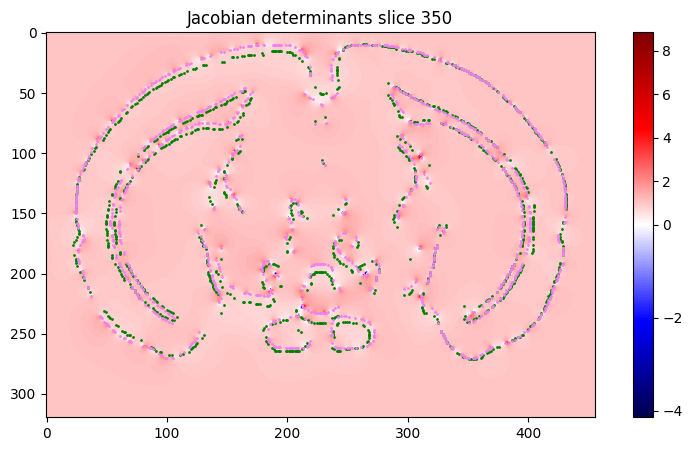

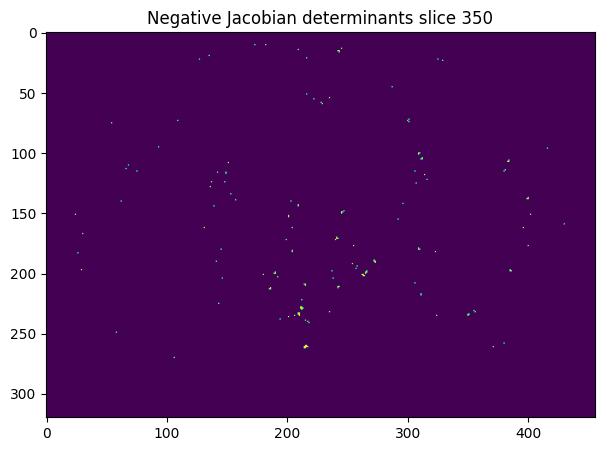

In [14]:
CURR_IDX = 350  # Only consider the correspondences of this index

# Input parameters
base_path = "data/corrected_correspondences_count_touching/registered_output/deformation3d.npy"
mpoints_path = "data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "data/corrected_correspondences_count_touching/fpoints.npy"

# Load the numpy array and compute the jacobian determinant
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

# Get only elements that are of the current index
mpoints = mpoints[mpoints[:, 0] == CURR_IDX]
fpoints = fpoints[fpoints[:, 0] == CURR_IDX]

# Change the 0th index in each element to 0
mpoints[:, 0] = 0
fpoints[:, 0] = 0

cvectors = fpoints - mpoints  # Correspondence vectors
cvectors = mpoints - fpoints  # Correspondence vectors

print("Correspondence point shape:", fpoints.shape)
print("\nFirst five fixed points:\n", fpoints[:5])
print("First five moving points:\n", mpoints[:5])
print("First five correspondence vectors:\n", cvectors[:5])

# Get Jacobian determinant field
fixed_resolution = np.zeros((1, 320, 456))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet_field = jacobian.sitk_jacobian_determinant(deformation)[0]
negative_jdet_field = jdet_field <= 0
negative_jdet_field = negative_jdet_field.astype(bool)
clabels = label_correspondences(fpoints, jdet_field)

norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())

# Print the number of negative or zero Jacobian determinants
print("\nNumber of negative or zero Jacobian determinants:", np.sum(jdet_field <= 0))
print("Number of negative or zero Jacobian determinants:", np.sum(negative_jdet_field))
print("Minimum Jacobian determinant:", jdet_field.min())
print()

# Plot the Jacobian determinant values
f = plt.figure(figsize=(10, 5))
plt.imshow(jdet_field, cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title(f"Jacobian determinants slice {CURR_IDX}")
plt.show()
f.clear()
plt.close(f)

# Plot the negative Jacobian determinants
f = plt.figure(figsize=(10, 5))
plt.imshow(negative_jdet_field, cmap='viridis')
plt.title(f"Negative Jacobian determinants slice {CURR_IDX}")
plt.show()
f.clear()
plt.close(f)

In [11]:
deformation[:, 0, :, :].shape

(3, 320, 456)

## Show LUT

  0%|          | 0/320 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:05<00:00, 60.18it/s]


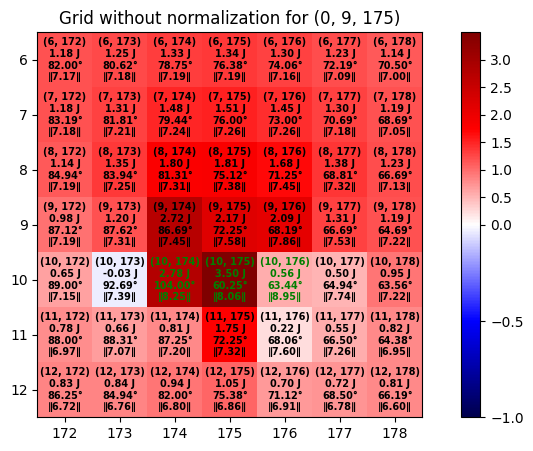

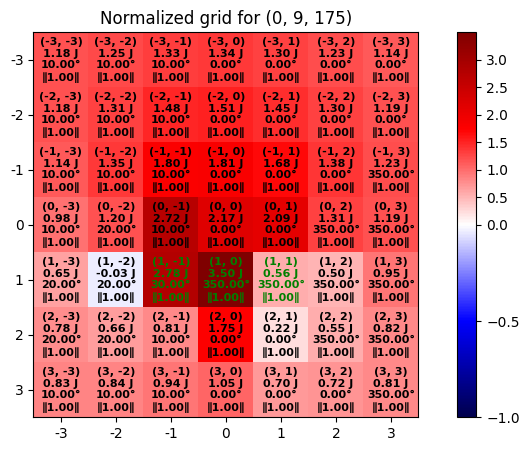

In [ ]:
def is_array_in_array(sub_array, main_array):
    return any(np.array_equal(sub_array, element) for element in main_array)


def find_array_index(sub_array, main_array):
    for index, element in enumerate(main_array):
        if np.array_equal(sub_array, element):
            return index
    return -1  # Return -1 if the sub-array is not found

def create_grid(deformation: np.ndarray, jdet_field: np.ndarray, fpoints: np.ndarray, mpoints: np.ndarray):
    """
    Creates a full grid of correspondence information.
    
    Parameters:
    jdet_field (np.ndarray): The Jacobian determinant field.
    fpoints (np.ndarray): The fixed points.
    mpoints (np.ndarray): The moving points.
    
    Returns:
    np.ndarray: The grid of points. Each element contains the following information:
        - y (int): The y-coordinate of the point.
        - x (int): The x-coordinate of the point.
        - theta (float): The angle of the vector relative to the x-axis.
        - magnitude (float): The magnitude
        - Jdet (float): The Jacobian determinant value at the point.
        - is_correspondence (bool): Whether the point is a correspondence.
    """
    # Initialize the grid as an object array
    grid_y = np.empty(jdet_field.shape, dtype=np.int16)
    grid_x = np.empty(jdet_field.shape, dtype=np.int16)
    grid_theta = np.empty(jdet_field.shape, dtype=np.float16)
    grid_magnitude = np.empty(jdet_field.shape, dtype=np.float16)
    grid_jdet = np.empty(jdet_field.shape, dtype=np.float16)
    grid_correspondence = np.zeros(jdet_field.shape, dtype=bool)

    # Store all information about correspondences into the grid
    y_resolution = jdet_field.shape[0]
    x_resolution = jdet_field.shape[1]
    curr_deformation = deformation[:, 0, :, :]  # (3, 320, 456)
    for y in tqdm(range(y_resolution)):
        for x in range(x_resolution):
            curr_displacement_vector = curr_deformation[:, y, x]
            _, displacement_y, displacement_x = curr_displacement_vector
            
            
            # Get current pixel information
            theta = np.arctan2(displacement_y, displacement_x)                # Angle of the vector relative to the x-axis
            if theta < 0:  # Ensure the angle is in the range [0, 2pi)
                theta += 2 * np.pi
            magnitude = np.linalg.norm(curr_displacement_vector)              # Magnitude of the vector
            jdet_value = jdet_field[y, x]                                     # Jacobian determinant value
            is_correspondence = np.any(np.all([0, y, x] == fpoints, axis=1))  # Whether the point is a correspondence
            
            # Place these values into the grid
            grid_y[y, x] = y
            grid_x[y, x] = x
            grid_theta[y, x] = theta
            grid_magnitude[y, x] = magnitude
            grid_jdet[y, x] = jdet_value
            grid_correspondence[y, x] = is_correspondence
        
    return [grid_y, grid_x, grid_theta, grid_magnitude, grid_jdet, grid_correspondence]


def get_local_grid(coord: tuple, grids: list, n: int=7, normalize=True):
    """
    Get the n x n grid of points around the coordinate.
    
    Parameters:
    coord (tuple): The coordinate of the point.
    grids (list): The grid of deformation information.
    n (int): The size of the grid.
    
    Returns:
    list: A n x n set of grids normalized around the coordinate.
    """
    # Get the current coordinate information
    if len(coord) == 2:
        y, x = coord
    else:
        z, y, x = coord
        
    grid_y, grid_x, grid_theta, grid_magnitude, grid_jdet, grid_correspondence = grids
    curr_theta = grid_theta[y, x]
    curr_magnitude = grid_magnitude[y, x]
    if curr_magnitude == 0 and normalize:  # Rescale the magnitude to 0.5 if it is 0 and if we want to normalize it relative to the coordinate
        curr_magnitude = 0.5  
    
    # Get the bounds of the grid
    y_min = int(max(y - (n // 2), 0))
    y_max = int(min(y + (n // 2) + 1, grid_y.shape[0]))
    x_min = int(max(x - (n // 2), 0))
    x_max = int(min(x + (n // 2) + 1, grid_y.shape[1]))
    
    # Crop the grid to the bounds
    grid_y = grid_y[y_min:y_max, x_min:x_max]
    grid_x = grid_x[y_min:y_max, x_min:x_max]
    grid_theta = grid_theta[y_min:y_max, x_min:x_max]
    grid_magnitude = grid_magnitude[y_min:y_max, x_min:x_max]
    grid_jdet = grid_jdet[y_min:y_max, x_min:x_max]
    grid_correspondence = grid_correspondence[y_min:y_max, x_min:x_max]
    
    if not normalize:  # Don't do any additional operations, just return the raw local values
        grid_theta = np.degrees(grid_theta)  # Convert radians to degrees
        return [grid_y, grid_x, grid_theta, grid_magnitude, grid_jdet, grid_correspondence]
    
    # Normalize grid_y and grid_x to be centered around the coordinate
    grid_y = grid_y - y
    grid_x = grid_x - x
    
    # Normalize theta to be centered around the coordinate, calculate the nearest angle from the current angle
    grid_theta = grid_theta - curr_theta
    # Uncomment the bottom 3 lines to get the nearest angle from the current angle
    #grid_theta1 = np.abs(grid_theta - curr_theta)
    #grid_theta2 = np.abs(np.pi - (grid_theta - curr_theta))
    #grid_theta = np.minimum(grid_theta1, grid_theta2)
    grid_theta[grid_theta < 0] += 2 * np.pi  # Ensure the angle is in the range [0, 2pi) after subtraction
    grid_theta = np.degrees(grid_theta)  # Convert radians to degrees
    grid_theta = np.round(grid_theta / 10) * 10  # Round theta to the nearest 10 degrees
    grid_theta[grid_theta == 360] = 0  # Ensure 360 degrees is 0 degrees
    
    # Normalize magnitude to be centered around the coordinate, round to the nearest 0.5 and clip to 0.5-5.0
    grid_magnitude = grid_magnitude / curr_magnitude
    grid_magnitude = np.round(grid_magnitude * 2) / 2
    grid_magnitude = np.clip(grid_magnitude, 0.5, 5.0)
    
    return [grid_y, grid_x, grid_theta, grid_magnitude, grid_jdet, grid_correspondence]


def show_grid(grids: list, title="", fontsize=8):
    """
    Show the grid of deformation information.
    
    Parameters:
    grids (list): The grid of deformation information.
    """
    grid_y, grid_x, grid_theta, grid_magnitude, grid_jdet, grid_correspondence = grids
    norm = mcolors.TwoSlopeNorm(vmin=min(grid_jdet.min(), -1), vcenter=0, vmax=grid_jdet.max())
    
    # Plot the grid of deformation information
    f = plt.figure(figsize=(10, 5))
    
    
    # Plot the grid of Jacobian determinants color values
    plt.imshow(grid_jdet, cmap="seismic", norm=norm)
    plt.colorbar()
    
    # Plot the coordinate text
    for j in range(grid_y.shape[0]):
        for i in range(grid_y.shape[1]):
            # Get the pixel information
            y = grid_y[j, i]
            x = grid_x[j, i]
            degrees = grid_theta[j, i]
            magnitude = grid_magnitude[j, i]
            jdet = grid_jdet[j, i]
            is_correspondence = grid_correspondence[j, i]
            
            # Setup text to display
            coord_text = f"({y}, {x})\n"
            vector_text = f"\n{degrees:.2f}°\n" + f"∥{magnitude:.2f}∥"
            jdet_text = f"{jdet:.2f} J"
            pixel_text = coord_text + jdet_text + vector_text
            if is_correspondence:
                text_color = "green"
            else:
                text_color = "black"
            plt.text(i, j, pixel_text, color=text_color, ha='center', va='center', fontsize=fontsize, weight='bold')

    # Set the xticks and yticks
    plt.xticks(np.arange(grid_x.shape[0]), labels=np.arange(np.min(grid_x), np.max(grid_x) + 1))
    plt.yticks(np.arange(grid_y.shape[0]), labels=np.arange(np.min(grid_y), np.max(grid_y) + 1))
    
    # Set the title
    plt.title(title)
    
    plt.show()
    f.clear()
    plt.close(f)
    
    
curr_coordinate = (0, 9, 175)

# Create the grid of deformation information
grids = create_grid(deformation, jdet_field, fpoints, mpoints)
local_grids_no_norm = get_local_grid(curr_coordinate, grids, n=7, normalize=False)
local_grids = get_local_grid(curr_coordinate, grids, n=7, normalize=True)
grid_y, grid_x, grid_theta, grid_magnitude, grid_jdet, grid_correspondence = local_grids

# Show the grid of deformation information
show_grid(local_grids_no_norm, fontsize=7, title=f"Grid without normalization for {curr_coordinate}")
show_grid(local_grids, fontsize=8, title=f"Normalized grid for {curr_coordinate}")

In [75]:
np.arange(0, 5)

array([0, 1, 2, 3, 4])

In [24]:

def show_grid(grid: np.ndarray, jdet_field: np.ndarray, fontsize=6, title=None):
    """
    Show the grid of points.
    
    Parameters:
    grid (np.ndarray): The grid of points.
    jdet_field (np.ndarray): The Jacobian determinant field.
    """
    # Create a colormap for the Jacobian determinant field
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())
    magnitude_scale = 0.33  # To scale the vector magnitude for visualization purposes
    
    # Initialize the figure
    f = plt.figure(figsize=(20, 10))
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    
    # Write coordinates on the plot
    for j in range(grid.shape[0]):
        for i in range(grid.shape[1]):
            if grid[j, i] is not None:
                y, x, theta, magnitude = grid[j, i]
                degrees = np.degrees(theta)
                
                # Write coordinate text
                coord_text = f"({y}, {x})\n\n"
                vector_text = f"\n{degrees:.2f}°\n" + f"{magnitude:.2f}"
                jdet_text = f"[{jdet_field[j, i]:.2f}]"
                pixel_text = coord_text + jdet_text + vector_text
                plt.text(i, j, pixel_text, color="black", ha='center', va='center', fontsize=fontsize, weight='bold')
                #plt.text(i, j, coord_text, color="black", ha='center', va='bottom', fontsize=fontsize, weight='bold')   # Coordinate
                #plt.text(i, j, vector_text, color="black", ha='center', va='top', fontsize=fontsize, weight='bold')     # Vector info
                #plt.text(i, j, jdet_text, color="black", ha='center', va='center', fontsize=fontsize, weight='normal')  # Jdet
                plt.arrow(i, j, np.cos(theta) * magnitude_scale, np.sin(theta) * magnitude_scale, head_width=0.15, head_length=0.15, fc='green', ec='green')
    
    # Set the title and show the plot
    if title is None:
        plt.title(f"Neighborhood grid {grid.shape[0]} x {grid.shape[1]}")
    else:
        plt.title(title)
    plt.show()
    f.clear()
    plt.close(f)
    
    
def get_neighbors(grid: np.ndarray):
    """
    Get the neighbors of the central point in the grid.
    
    Parameters:
    grid (np.ndarray): The grid of points.
    
    Returns:
    np.ndarray: The neighbors in the grid.
    """
    # Initialize the neighbors array
    neighbors = []
    
    # Central coordinate
    central_y = grid.shape[0] // 2
    central_x = grid.shape[1] // 2
    
    # Iterate through each point in the grid
    for j in range(grid.shape[0]):
        for i in range(grid.shape[1]):
            is_central = (j == central_y and i == central_x)
            if grid[j, i] is not None and not is_central:  # Avoid returning central point as neighbor
                # Store the neighborhood in the neighbors array
                neighbors.append(grid[j, i])
    return neighbors


def get_central_point(grid: np.ndarray):
    """
    Get the central point in the grid.
    
    Parameters:
    grid (np.ndarray): The grid of points.
    
    Returns:
    tuple: The central point.
    """
    # Central coordinate
    central_y = grid.shape[0] // 2
    central_x = grid.shape[1] // 2
    
    return grid[central_y, central_x]



# Setup grid

In [25]:
# Print some sample negative Jdet coordinates for use
neg_coordinates = get_negative_jdet_coordinates(jdet_field)
print("Negative Jacobian determinant coordinates:")
pprint(neg_coordinates[-15:])

Negative Jacobian determinant coordinates:
array([[239, 215],
       [240, 217],
       [241, 218],
       [249,  58],
       [258, 380],
       [260, 215],
       [260, 216],
       [261, 214],
       [261, 215],
       [261, 216],
       [261, 217],
       [261, 371],
       [262, 214],
       [262, 215],
       [270, 106]])


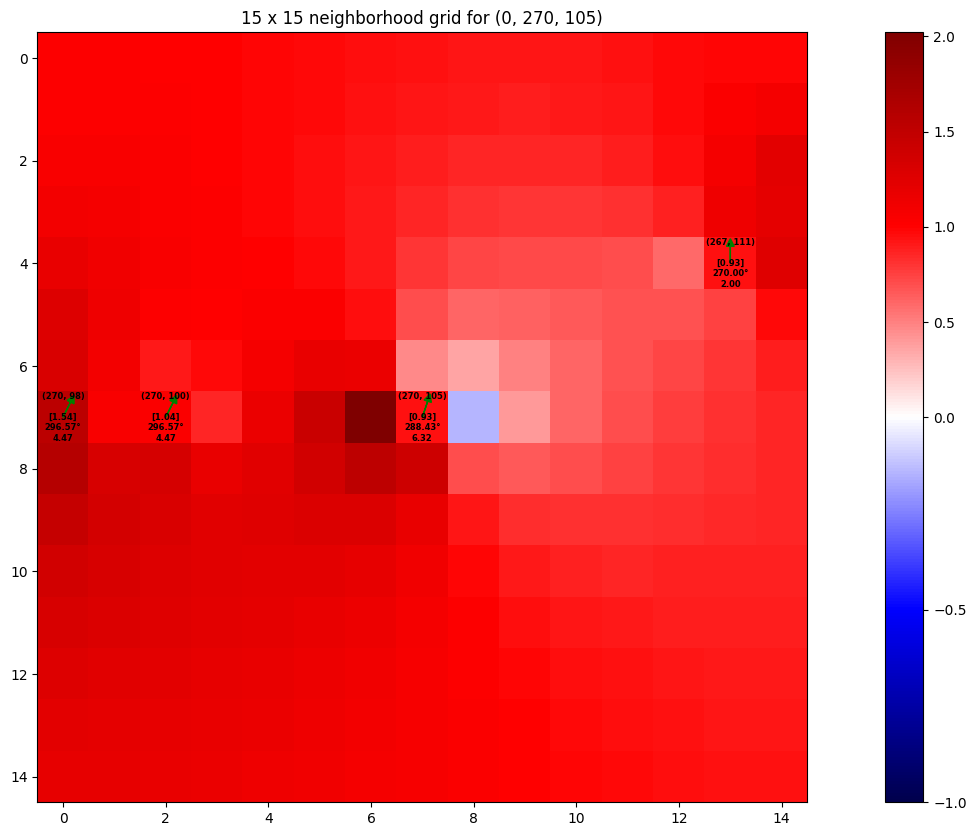

In [26]:
# Input parameters
curr_coord = (0, 270, 105) # (0, 10, 175)
n = 15

# Populate the grid with the correspondence information
full_grid = create_grid(jdet_field, fpoints, mpoints)

# Get a local grid sample
curr_grid, curr_jdet_field = local_grid(curr_coord, full_grid, jdet_field, n=n)
show_grid(curr_grid, curr_jdet_field, title=f"{n} x {n} neighborhood grid for {curr_coord}")

## Set up scoring for current grid

In [50]:
weight_magnitude = 0.5  # 0.8
weight_theta = 0.5  # 0.2

# Get the neighbors and central point
neighbors = get_neighbors(curr_grid)
central_point = get_central_point(curr_grid)

# Get the central point information
central_y, central_x, central_theta, central_magnitude = central_point


# Get the normalized magnitudes and angles of the neighbors
neighbor_info = []
for neighbor in neighbors:
    y, x, theta, magnitude = neighbor
    distance = np.linalg.norm(np.array([y, x]) - np.array([central_y, central_x]))
    normalized_theta = abs(theta - central_theta)
    if central_magnitude == 0:
        normalized_magnitude = 0
    else:
        normalized_magnitude = magnitude / central_magnitude
    neighbor_info.append((distance, normalized_theta, normalized_magnitude))    

# Get neighbor metrics
neighbor_distances = np.array([neighbor[0] for neighbor in neighbor_info])
neighbor_thetas = np.array([neighbor[1] for neighbor in neighbor_info])
neighbor_magnitudes = np.array([neighbor[2] for neighbor in neighbor_info])


# Compute score between central point and neighbors
CURR_NEIGHBOR_IDX = 0

curr_neighbor = neighbor_info[CURR_NEIGHBOR_IDX]
curr_neighbor_distance, curr_neighbor_theta, curr_neighbor_magnitude = curr_neighbor

# Compute the penalties for distance
max_distance = np.sqrt((curr_grid.shape[0]/2)**2 + (curr_grid.shape[1]/2)**2)
# max_distance = np.max(neighbor_distances)
distance_weight = (max_distance - curr_neighbor_distance) / max_distance
distance_weight = 1

# Compute the penalties for theta
theta_penalty = curr_neighbor_theta / np.pi

# Compute the penalties for magnitude
magnitude_variance = np.var(neighbor_magnitudes)
max_difference = np.max(neighbor_magnitudes)
scaling_factor = 2.0  # Influences local variance on penalty for magnitude differences
magnitude_penalty = abs(curr_neighbor_magnitude - 1) * (1 + scaling_factor * magnitude_variance)

# Compute the score
score = 1 - distance_weight * (weight_theta * theta_penalty + weight_magnitude * magnitude_penalty)


print("Current point:", central_point)
print("Current neighbor index:", CURR_NEIGHBOR_IDX)
print("\nNeighbors:")
pprint(neighbors)

print("\nNeighbor information [distance, normalized theta, normalized magnitude]:")
pprint(neighbor_info)

print("\nCurrent neighbor:")
print("\tDistance:", curr_neighbor_distance, "Theta:", curr_neighbor_theta, "Magnitude:", curr_neighbor_magnitude)
print("Score:", score)
print("\tDistance penalty:", distance_weight)
print("\tTheta penalty:", theta_penalty)
print("\tMagnitude penalty:", magnitude_penalty)

Current point: (270, 356, 3.9269908169872414, 1.4142135623730951)
Current neighbor index: 0

Neighbors:
[(267, 362, 3.9269908169872414, 1.4142135623730951),
 (268, 360, 4.2487413713838835, 2.23606797749979),
 (269, 358, 4.3906384259880475, 3.1622776601683795),
 (270, 349, 4.2487413713838835, 2.23606797749979),
 (270, 351, 4.2487413713838835, 2.23606797749979),
 (270, 354, 3.141592653589793, 1.0),
 (270, 355, 3.141592653589793, 1.0)]

Neighbor information [distance, normalized theta, normalized magnitude]:
[(6.708203932499369, 0.0, 1.0),
 (4.47213595499958, 0.32175055439664213, 1.5811388300841895),
 (2.23606797749979, 0.46364760900080615, 2.23606797749979),
 (7.0, 0.32175055439664213, 1.5811388300841895),
 (5.0, 0.32175055439664213, 1.5811388300841895),
 (2.0, 0.7853981633974483, 0.7071067811865475),
 (1.0, 0.7853981633974483, 0.7071067811865475)]

Current neighbor:
	Distance: 6.708203932499369 Theta: 0.0 Magnitude: 1.0
Score: 1.0
	Distance penalty: 1
	Theta penalty: 0.0
	Magnitude pena

## Run scoring on all neighbors

In [51]:
consensus_thresh = 0.5

consensus = []
# Compute score between central point and ALL neighbors
for i in range(len(neighbor_info)):
    CURR_NEIGHBOR_IDX = i
    curr_neighbor = neighbor_info[CURR_NEIGHBOR_IDX]
    curr_neighbor_distance, curr_neighbor_theta, curr_neighbor_magnitude = curr_neighbor

    # Compute the penalties for distance
    max_distance = np.sqrt((curr_grid.shape[0]/2)**2 + (curr_grid.shape[1]/2)**2)
    # max_distance = np.max(neighbor_distances)
    distance_weight = (max_distance - curr_neighbor_distance) / max_distance
    distance_weight = 1

    # Compute the penalties for theta
    theta_penalty = curr_neighbor_theta / np.pi

    # Compute the penalties for magnitude
    magnitude_variance = np.var(neighbor_magnitudes)
    max_difference = np.max(neighbor_magnitudes)
    scaling_factor = 2.0  # Influences local variance on penalty for magnitude differences
    magnitude_penalty = abs(curr_neighbor_magnitude - 1) * (1 + scaling_factor * magnitude_variance)

    # Compute the score
    score = 1 - distance_weight * (weight_theta * theta_penalty + weight_magnitude * magnitude_penalty)
    if score >= consensus_thresh:
        consensus.append(1)
    else:
        consensus.append(0)

    #print("Current point:", central_point)
    #print("Current neighbor index:", CURR_NEIGHBOR_IDX)
    #print("\nNeighbors:")
    #pprint(neighbors)

    #print("\nNeighbor information [distance, normalized theta, normalized magnitude]:")
    #pprint(neighbor_info)

    print(f"\n({neighbors[i][0]}, {neighbors[i][1]})")
    print("Score:", score)
    #print("\tDistance penalty:", distance_weight)
    print("\tTheta penalty:", theta_penalty)
    print("\tMagnitude penalty:", magnitude_penalty)

print("\nConsensus:", f"{np.sum(consensus)}/{len(consensus)}", "positive.")
if np.sum(consensus) >= len(consensus) / 2:
    print("Correspondence is labeled \'good\'.")
else:
    print("Correspondence is labeled \'bad\'.")


(267, 362)
Score: 1.0
	Theta penalty: 0.0
	Magnitude penalty: 0.0

(268, 360)
Score: 0.5009776437381837
	Theta penalty: 0.10241638234956671
	Magnitude penalty: 0.895628330174066

(269, 358)
Score: -0.026281507809358118
	Theta penalty: 0.1475836176504333
	Magnitude penalty: 1.9049793979682828

(270, 349)
Score: 0.5009776437381837
	Theta penalty: 0.10241638234956671
	Magnitude penalty: 0.895628330174066

(270, 351)
Score: 0.5009776437381837
	Theta penalty: 0.10241638234956671
	Magnitude penalty: 0.895628330174066

(270, 354)
Score: 0.6493022399250132
	Theta penalty: 0.25
	Magnitude penalty: 0.4513955201499735

(270, 355)
Score: 0.6493022399250132
	Theta penalty: 0.25
	Magnitude penalty: 0.4513955201499735

Consensus: 6/7 positive.
Correspondence is labeled 'good'.


## Run on whole slice

In [97]:
consensus_thresh = 0.5
n = 15  # 15
weight_magnitude = 0.75  # 0.8
weight_theta = 0.75  # 0.2
    
scored_labels = []
for j in tqdm(range(len(fpoints))):
    
    # Input parameters
    curr_coord = fpoints[j] # (0, 10, 175)

    # Populate the grid with the correspondence information
    full_grid = create_grid(jdet_field, fpoints, mpoints)

    # Get a local grid sample
    curr_grid, curr_jdet_field = local_grid(curr_coord, full_grid, jdet_field, n=n)
    #show_grid(curr_grid, curr_jdet_field, title=f"{n} x {n} neighborhood grid for {curr_coord}")
    
    # Get the neighbors and central point
    neighbors = get_neighbors(curr_grid)
    
    #central_point = get_central_point(curr_grid)
    central_point = full_grid[int(curr_coord[1]), int(curr_coord[2])]

    # Get the central point information
    central_y, central_x, central_theta, central_magnitude = central_point


    # Get the normalized magnitudes and angles of the neighbors
    neighbor_info = []
    for neighbor in neighbors:
        y, x, theta, magnitude = neighbor
        distance = np.linalg.norm(np.array([y, x]) - np.array([central_y, central_x]))
        normalized_theta = abs(theta - central_theta)
        if central_magnitude == 0:
            normalized_magnitude = 0
        else:
            normalized_magnitude = magnitude / central_magnitude
        neighbor_info.append((distance, normalized_theta, normalized_magnitude))    

    # Get neighbor metrics
    neighbor_distances = np.array([neighbor[0] for neighbor in neighbor_info])
    neighbor_thetas = np.array([neighbor[1] for neighbor in neighbor_info])
    neighbor_magnitudes = np.array([neighbor[2] for neighbor in neighbor_info])

            
    consensus = []
    # Compute score between central point and ALL neighbors
    for i in range(len(neighbor_info)):
        CURR_NEIGHBOR_IDX = i
        curr_neighbor = neighbor_info[CURR_NEIGHBOR_IDX]
        curr_neighbor_distance, curr_neighbor_theta, curr_neighbor_magnitude = curr_neighbor

        # Compute the penalties for distance
        max_distance = np.sqrt((curr_grid.shape[0]/2)**2 + (curr_grid.shape[1]/2)**2)
        # max_distance = np.max(neighbor_distances)
        distance_weight = (max_distance - curr_neighbor_distance) / max_distance
        distance_weight = 1

        # Compute the penalties for theta
        theta_penalty = curr_neighbor_theta / np.pi

        # Compute the penalties for magnitude
        magnitude_variance = np.var(neighbor_magnitudes)
        max_difference = np.max(neighbor_magnitudes)
        scaling_factor = 2.0  # Influences local variance on penalty for magnitude differences
        magnitude_penalty = abs(curr_neighbor_magnitude - 1) * (1 + scaling_factor * magnitude_variance)

        # Compute the score
        score = 1 - distance_weight * (weight_theta * theta_penalty + weight_magnitude * magnitude_penalty)
        
        if score >= consensus_thresh: # or neighbors[i][2] == 0 and neighbors[i][3] == 0:
            consensus.append(1)
        else:
            consensus.append(0)

        #print("Current point:", central_point)
        #print("Current neighbor index:", CURR_NEIGHBOR_IDX)
        #print("\nNeighbors:")
        #pprint(neighbors)

        #print("\nNeighbor information [distance, normalized theta, normalized magnitude]:")
        #pprint(neighbor_info)

        ##print(f"\n({neighbors[i][0]}, {neighbors[i][1]})")
        ##print("Score:", score)
        #print("\tDistance penalty:", distance_weight)
        ##print("\tTheta penalty:", theta_penalty)
        ##print("\tMagnitude penalty:", magnitude_penalty)

    #print("\nConsensus:", f"{np.sum(consensus)}/{len(consensus)}", "positive.")
    if np.sum(consensus) >= len(consensus) / 2:
        #print("Correspondence is labeled \'good\'.")
        scored_labels.append(1)
    else:
        #print("Correspondence is labeled \'bad\'.")
        scored_labels.append(0)

100%|██████████| 1246/1246 [00:11<00:00, 110.83it/s]


In [98]:
def compute_accuracy(predicted, ground_truth):
    """
    Compute the accuracy of the predicted labels.
    
    Parameters:
    predicted (np.ndarray): The predicted labels.
    ground_truth (np.ndarray): The ground truth labels.
    
    Returns:
    float: The accuracy of the predicted labels.
    """
    predicted = np.array(predicted)
    ground_truth = np.array(ground_truth)
    # Compute the true positives
    true_positives = np.sum(np.logical_and(predicted == 1, ground_truth == 1))
    
    # Compute the true negatives
    true_negatives = np.sum(np.logical_and(predicted == 0, ground_truth == 0))
    
    # Compute the accuracy
    accuracy = (true_positives + true_negatives) / len(ground_truth)
    
    return accuracy


def compute_precision(prediction, ground_truth):
    """
    Compute the precision between two 1D binary arrays.
    
    Parameters:
    prediction (np.ndarray): The predicted binary labels.
    ground_truth (np.ndarray): The true binary labels.
    
    Returns:
    float: The precision score.
    """
    prediction = np.array(prediction)
    ground_truth = np.array(ground_truth)
    true_positive = np.sum((prediction == 1) & (ground_truth == 1))
    false_positive = np.sum((prediction == 1) & (ground_truth == 0))
    
    if true_positive + false_positive == 0:
        return 0.0
    
    precision = true_positive / (true_positive + false_positive)
    return precision


def compute_recall(predicted, ground_truth):
    """
    Compute the recall of the predicted labels.
    
    Parameters:
    predicted (np.ndarray): The predicted labels.
    ground_truth (np.ndarray): The ground truth labels.
    
    Returns:
    float: The recall of the predicted labels.
    """
    predicted = np.array(predicted)
    ground_truth = np.array(ground_truth)
    # Compute the true positives
    true_positives = np.sum(np.logical_and(predicted == 1, ground_truth == 1))
    
    # Compute the false negatives
    false_negatives = np.sum(np.logical_and(predicted == 0, ground_truth == 1))
    
    # Compute the recall
    recall = true_positives / (true_positives + false_negatives)
    
    return recall


def compute_specificity(predicted, ground_truth):
    """
    Compute the specificity of the predicted labels.
    
    Parameters:
    predicted (np.ndarray): The predicted labels.
    ground_truth (np.ndarray): The ground truth labels.
    
    Returns:
    float: The specificity of the predicted labels.
    """
    predicted = np.array(predicted)
    ground_truth = np.array(ground_truth)
    # Compute the true negatives
    true_negatives = np.sum(np.logical_and(predicted == 0, ground_truth == 0))
    
    # Compute the false positives
    false_positives = np.sum(np.logical_and(predicted == 1, ground_truth == 0))
    
    # Compute the specificity
    specificity = true_negatives / (true_negatives + false_positives)
    
    return specificity


def get_false_positive_indices(predicted, ground_truth):
    """
    Get the indices of the false positives.
    
    Parameters:
    predicted (np.ndarray): The predicted labels.
    ground_truth (np.ndarray): The ground truth labels.
    
    Returns:
    np.ndarray: The indices of the false positives.
    """
    predicted = np.array(predicted)
    ground_truth = np.array(ground_truth)
    false_positives = np.where(np.logical_and(predicted == 1, ground_truth == 0))[0]
    return false_positives


def get_false_negative_indices(predicted, ground_truth):
    """
    Get the indices of the false negatives.
    
    Parameters:
    predicted (np.ndarray): The predicted labels.
    ground_truth (np.ndarray): The ground truth labels.
    
    Returns:
    np.ndarray: The indices of the false negatives.
    """
    predicted = np.array(predicted)
    ground_truth = np.array(ground_truth)
    false_negatives = np.where(np.logical_and(predicted == 0, ground_truth == 1))[0]
    return false_negatives


print("How many positively identified Jdets: ", np.sum(scored_labels))
print("Ground truth positive Jdets:", np.sum(clabels))
print("Number of false positives:", len(get_false_positive_indices(scored_labels, clabels)))
print("Number of false negatives:", len(get_false_negative_indices(scored_labels, clabels)))
print("\nAccuracy:", compute_accuracy(scored_labels, clabels))
print("Precision:", compute_precision(scored_labels, clabels))
print("Recall:", compute_recall(scored_labels, clabels))
print("Specificity:", compute_specificity(scored_labels, clabels))

How many positively identified Jdets:  647
Ground truth positive Jdets: 1127
Number of false positives: 56
Number of false negatives: 536

Accuracy: 0.5248796147672552
Precision: 0.9134466769706336
Recall: 0.5244010647737356
Specificity: 0.5294117647058824


n=15, wt 0.5 0.5
How many positively identified Jdets:  909
Ground truth positive Jdets: 1127
Accuracy: 0.6934189406099518
Precision: 0.9097909790979097
Recall: 0.7338065661047027
Specificity: 0.31092436974789917

n=35 wt 0.5 0.5
How many positively identified Jdets:  695
Ground truth positive Jdets: 1127
Accuracy: 0.5666131621187801
Precision: 0.9223021582733812
Recall: 0.5687666370896185
Specificity: 0.5462184873949579

## Analyze false negatives and false positives

In [87]:
fn_idx = get_false_negative_indices(scored_labels, clabels)
fp_idx = get_false_positive_indices(scored_labels, clabels)
print(fp_idx)

[   1    3   55   75   78   87  168  185  211  217  273  290  311  437
  491  496  509  541  557  565  569  577  581  599  611  615  617  629
  673  682  698  711  713  747  751  791  814  862  864  882  903  959
  960 1003 1035 1050 1069 1074 1075 1095 1109 1132 1196 1240]


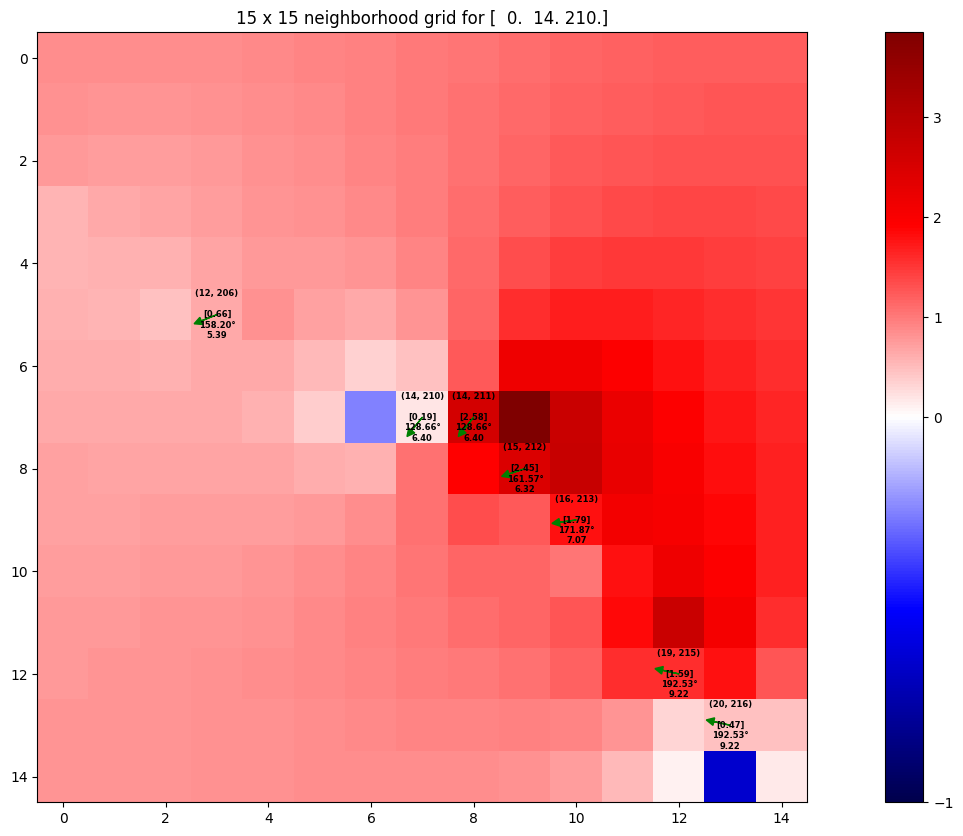


(12, 206)
Score: 0.8301613156244236
	Theta penalty: 0.1641043458864338
	Magnitude penalty: 0.17557302286471888

(14, 211)
Score: 1.0
	Theta penalty: 0.0
	Magnitude penalty: 0.0

(15, 212)
Score: 0.9018209423053367
	Theta penalty: 0.1828069051277105
	Magnitude penalty: 0.013551210261616192

(16, 213)
Score: 0.8223700356735335
	Theta penalty: 0.24005605217641063
	Magnitude penalty: 0.1152038764765223

(19, 215)
Score: 0.5797044235612397
	Theta penalty: 0.35482777475034116
	Magnitude penalty: 0.4857633781271793

(20, 216)
Score: 0.5797044235612397
	Theta penalty: 0.35482777475034116
	Magnitude penalty: 0.4857633781271793

Consensus: 6/6 positive.
Correspondence is labeled 'good'.


In [88]:
# Input parameters
curr_coord = fpoints[55]
n = 15
consensus_thresh = 0.5
weight_magnitude = 0.5  # 0.8
weight_theta = 0.5  # 0.2


# Populate the grid with the correspondence information
full_grid = create_grid(jdet_field, fpoints, mpoints)

# Get a local grid sample
curr_grid, curr_jdet_field = local_grid(curr_coord, full_grid, jdet_field, n=n)
show_grid(curr_grid, curr_jdet_field, title=f"{n} x {n} neighborhood grid for {curr_coord}")

############################################################################################################



# Get the neighbors and central point
neighbors = get_neighbors(curr_grid)
# Remove neighbors from list that have 0 magnitude and 0 angle
neighbors = [neighbor for neighbor in neighbors if neighbor[2] != 0 and neighbor[3] != 0]

#central_point = get_central_point(curr_grid)
central_point = full_grid[int(curr_coord[1]), int(curr_coord[2])]

# Get the central point information
central_y, central_x, central_theta, central_magnitude = central_point


# Get the normalized magnitudes and angles of the neighbors
neighbor_info = []
for neighbor in neighbors:
    y, x, theta, magnitude = neighbor
    distance = np.linalg.norm(np.array([y, x]) - np.array([central_y, central_x]))
    normalized_theta = abs(theta - central_theta)
    if central_magnitude == 0:
        normalized_magnitude = 0
    else:
        normalized_magnitude = magnitude / central_magnitude
    neighbor_info.append((distance, normalized_theta, normalized_magnitude))    

# Get neighbor metrics
neighbor_distances = np.array([neighbor[0] for neighbor in neighbor_info])
neighbor_thetas = np.array([neighbor[1] for neighbor in neighbor_info])
neighbor_magnitudes = np.array([neighbor[2] for neighbor in neighbor_info])


consensus = []
# Compute score between central point and ALL neighbors
for i in range(len(neighbor_info)):
    CURR_NEIGHBOR_IDX = i
    curr_neighbor = neighbor_info[CURR_NEIGHBOR_IDX]
    curr_neighbor_distance, curr_neighbor_theta, curr_neighbor_magnitude = curr_neighbor

    # Compute the penalties for distance
    max_distance = np.sqrt((curr_grid.shape[0]/2)**2 + (curr_grid.shape[1]/2)**2)
    # max_distance = np.max(neighbor_distances)
    distance_weight = (max_distance - curr_neighbor_distance) / max_distance
    distance_weight = 1

    # Compute the penalties for theta
    theta_penalty = curr_neighbor_theta / np.pi

    # Compute the penalties for magnitude
    magnitude_variance = np.var(neighbor_magnitudes)
    max_difference = np.max(neighbor_magnitudes)
    scaling_factor = 2.0  # Influences local variance on penalty for magnitude differences
    magnitude_penalty = abs(curr_neighbor_magnitude - 1) * (1 + scaling_factor * magnitude_variance)

    # Compute the score
    score = 1 - distance_weight * (weight_theta * theta_penalty + weight_magnitude * magnitude_penalty)
    if score >= consensus_thresh:
        consensus.append(1)
    else:
        consensus.append(0)

    #print("Current point:", central_point)
    #print("Current neighbor index:", CURR_NEIGHBOR_IDX)
    #print("\nNeighbors:")
    #pprint(neighbors)

    #print("\nNeighbor information [distance, normalized theta, normalized magnitude]:")
    #pprint(neighbor_info)

    print(f"\n({neighbors[i][0]}, {neighbors[i][1]})")
    print("Score:", score)
    #print("\tDistance penalty:", distance_weight)
    print("\tTheta penalty:", theta_penalty)
    print("\tMagnitude penalty:", magnitude_penalty)

print("\nConsensus:", f"{np.sum(consensus)}/{len(consensus)}", "positive.")
if np.sum(consensus) >= len(consensus) / 2:
    print("Correspondence is labeled \'good\'.")
else:
    print("Correspondence is labeled \'bad\'.")